In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import pyccl as ccl


%load_ext autoreload
%autoreload 2




/tmp/ipykernel_1266709/2214155139.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = ccl.Cosmology(
    Omega_c=0.31-0.049, Omega_b=0.049, h=0.672, sigma8=0.81, n_s=0.95,
    transfer_function='eisenstein_hu')

k_array_ccl = np.logspace(-4, 2, 100)
z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl, a=1/(1+z))




In [5]:
from pyccl.halos.profiles import nfw
from pyccl.halos.profiles import pressure_gnfw
from pyccl.halos.concentration import duffy08





In [6]:
conc_model_ccl = duffy08.ConcentrationDuffy08()
nfw_prof_ccl = nfw.HaloProfileNFW(mass_def='200c',concentration=conc_model_ccl)



In [7]:
r_array = np.logspace(-2, 0, 100)
z_test = 0.0
h = cosmo['h']
M_test = 1.07710506e+14
conc = conc_model_ccl._concentration(cosmo,M_test/h,1/(1+z_test))



In [8]:
prof_test_ccl = nfw_prof_ccl._real(cosmo,r_array/h,M_test/h,1/(1+z_test))/(h**2)



In [9]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 16, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 10.0, 15.3, 64
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [10]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)



In [11]:
indc = np.where(BCMP_test.conc_array > 0.95*conc)[0][0]
indz = np.where(BCMP_test.z_array > 0.95*z_test)[0][0]
indM = np.where(BCMP_test.M_array > 0.95*M_test)[0][0]



(1000000000000.0, 20000000000000.0)

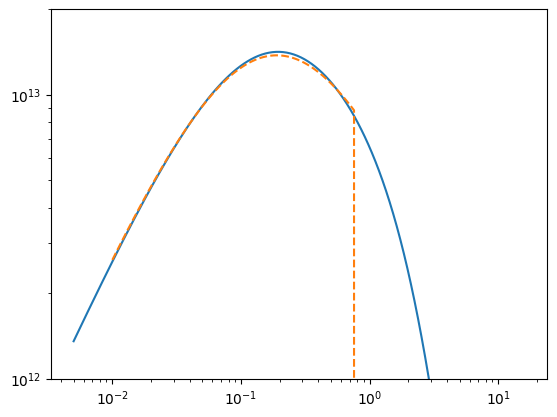

In [13]:
pl.figure()
pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,indc,indz,indM])
pl.loglog(r_array, (r_array**2)*prof_test_ccl, '--')
pl.ylim(1e12, 2e13)




In [14]:
from setup_power_spectra_jit import setup_power_BCMP

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, num_points_trapz_int=64, verbose_time=True)




Time taken to calculate BCMP profile:  4.549422025680542  seconds
Time taken to setup Pk:  7.067051410675049
Time taken to setup HMF:  8.488962650299072
Time taken to setup uks and bks:  1.5639441013336182
Time taken to setup uls and bls:  1.4292616844177246
Time taken to setup power spectra:  20.85095977783203


In [16]:
Pk_nfw = setup_power_BCMP_test.Pmm_nfw_tot_mat
Pk_dmb = setup_power_BCMP_test.Pmm_dmb_tot_mat
Pk_sup = setup_power_BCMP_test.Pmm_sup_tot_mat



In [17]:
k_array_ccl = setup_power_BCMP_test.k
z = z_test
# z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl*h, a=1/(1+z)) * h**3






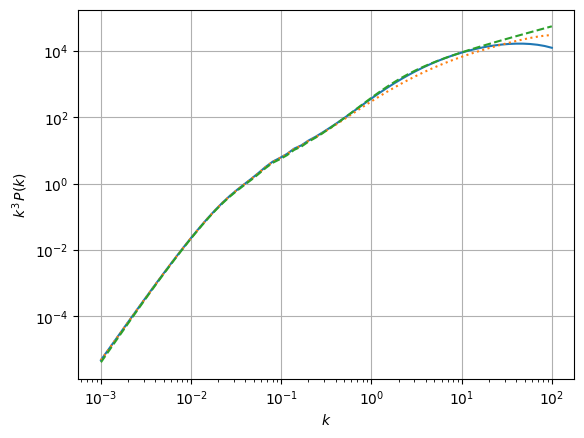

In [22]:
indz = 0
pl.figure()
pl.loglog(k_array_ccl, (k_array_ccl**3)*Pk_nfw[:,indz])
pl.loglog(k_array_ccl, (k_array_ccl**3)*Pk_dmb[:,indz], ls=':')
# pl.loglog(k_array_ccl, (k_array_ccl**3)*setup_power_BCMP_test.plin_kz_mat[:,indz])
pl.loglog(k_array_ccl, (k_array_ccl**3)*pkz_HF_ccl, '--')
pl.ylabel(r'$k^3 \, P(k)$')
pl.xlabel(r'$k$')
pl.grid()




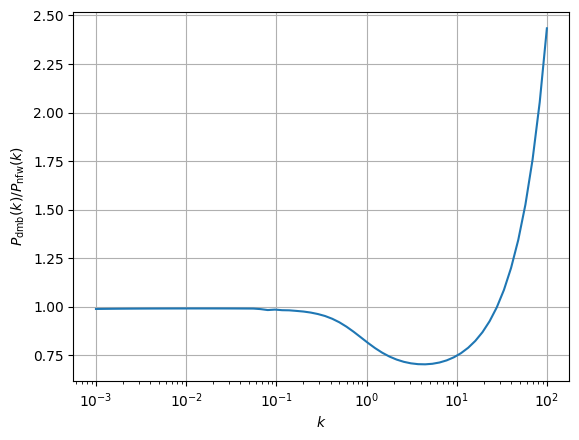

In [20]:
indz = 0
pl.figure()
pl.plot(k_array_ccl, Pk_sup[:,indz])
pl.xscale('log')
pl.ylabel(r'$P_{\rm dmb}(k)/P_{\rm nfw}(k)$')
pl.xlabel(r'$k$')
pl.grid()

